In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import AnaUtils as au
import os, glob
from datetime import datetime as dt

In [2]:
wdir = '/media/easystore/KA0206_LongDR_2020Q2/*'
fdirs = glob.glob(wdir)
fdirs.sort()
t0 = dt(2020, 3, 17, 0, 0)
fdirT = np.array([(dt.strptime(os.path.basename(idir)[21:27],'%y%m%d')-t0).days for idir in fdirs])
#fdirT = (np.array(fdirT)-fdirT[0]
fdirs,fdirT

(['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200317_250_samples_100000_events',
  '/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200318_250_samples_100000_events',
  '/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200319_250_samples_100000_events',
  '/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200320_250_samples_100000_events',
  '/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200321_250_samples_100000_events',
  '/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200322_250_samples_100000_events',
  '/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200323_250_samples_100000_events',
  '/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200403_250_samples_100000_events',
  '/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200404_250_samples_100000_events',
  '/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200405_250_samples_100000_events',
  '/media/easystore/KA0206_Lon

In [3]:
def DRun(fname,nbase=150,winS=5,winF=5,cut=4,pmt=0,qbins=1000,ret=False):
    waves = au.ReadDDC10_BinWave(fname)
    waves[0],base = au.Subtract_Baseline(waves[0],nBase=nbase)
    #require baseline has no pulse. i.e. integral over baseline less than cut*rms
    bmask = np.absolute(integrate.simps(waves[0][:,pmt,:nbase]))<cut*integrate.simps(np.ones(nbase))*base[1][:,pmt]
    PromptPeak = np.argmax(waves[0][:,pmt,:].sum(axis=0))
    Qhist = au.winQHist(waves,ch=pmt,init=PromptPeak-winS,end=PromptPeak+winF,nBins=qbins,hrange=[-3,10],evMask=bmask[...,np.newaxis])
    if ret:
        Qhist['waves'] = waves[0][:,pmt]
        Qhist['evMask'] = bmask
        Qhist['baserms'] = base[0][:,pmt]
        return Qhist,waves[1]
    else:
        return Qhist['qHist']
    
def plotQ(qhist,sdir):
    plt.errorbar(qhist[1],qhist[0],marker='+',yerr=np.sqrt(qhist[2]))
    plt.xlabel('Q [pC]')
    plt.ylabel('Rate [Hz]')
    plt.savefig(sdir+"/QHist.png")
    plt.show()
from scipy.optimize import curve_fit

def fitQ(Qhist,P,bounds=(-np.inf,np.inf),doErr=False):
    def gauss(x, x0, y0, sigma):
        p = [x0, y0, sigma]
        return p[1]* np.exp(-((x-p[0])/p[2])**2)
    def gauss2(x,x0,y0,s0,x1,y1,s1):
        p0 = gauss(x,x0,y0,s0)
        p1 = gauss(x,x1,y1,s1)
        return p0+p1
    def gauss3(x,x0,y0,s0,x1,y1,s1,x2,y2,s2):
        p0 = gauss(x,x0,y0,s0)
        p1 = gauss(x,x1,y1,s1)
        g2 = 2*x1 - x0 +x2
        p2 = gauss(x,g2,y2,s2)
        return p0+p1+p2
    ng = len(P)/3
    mx = Qhist[1]
    my = Qhist[0]
    merr = None
    abSig = None
    if doErr:
        args = Qhist[3]
        mx = mx[args]
        my = my[args]
        merr = np.sqrt(Qhist[2][args])
        abSig = True
    if ng==3:
        fit,tmp = curve_fit(gauss3,mx,my,p0=P,bounds=bounds,sigma=merr,absolute_sigma=abSig,maxfev=50000,ftol=1e-7,gtol=1e-7)
    elif ng==2:
        fit,tmp = curve_fit(gauss2,mx,my,p0=P,bounds=bounds,sigma=merr,absolute_sigma=abSig,maxfev=50000,ftol=1e-7,gtol=1e-7)
    elif ng==1:
        fit,tmp = curve_fit(gauss,mx,my,p0=P,bounds=bounds,sigma=merr,absolute_sigma=abSig,maxfev=50000,ftol=1e-7,gtol=1e-7)
    else:
        print('No valid fit function found')
        return None
    return fit,tmp

In [4]:
def fullAna(fdir,nbase=150,winS=5,winF=5,cut=4,pmt=0,qbins=200,ret=False):
    fnames = [os.path.splitext(iF)[0] for iF in glob.glob(fdir+'/*.bin')]
    avN = len(fnames)
    Qhist = list(DRun(fnames[0],nbase,winS,winF,cut,pmt,qbins,ret))
    for iQ in range(1,avN):
        Qhisti = DRun(fnames[iQ],nbase,winS,winF,cut,pmt,qbins,ret)
        Qhist[0] += Qhisti[0]
        Qhist[2] += Qhisti[2]
    Qhist[0] *= 1/float(avN)
    Qhist[2] *= 1/float(avN*avN)
    plotQ(Qhist,fdir)
    """
    popt,pcov = fitQ(Qhist,[0,10,1,3,1,1])
    QNoise = min([popt[0],popt[3]])
    QSPE = max([popt[0],popt[3]])
    Qbin0 = np.argmax(Qhist[1]>QNoise)
    Qbin1 = np.argmax(Qhist[1]>QSPE)
    print(popt)
    Qvalley = np.argmax(Qhist[1]>(QSPE/5))
    """
    Qbin0 = np.argmax(Qhist[1]>0)
    Qbin1 = np.argmax(Qhist[1]>2)
    Qvalley = Qbin0 + np.argmin(Qhist[0][Qbin0:Qbin1])
    DR = np.sum(Qhist[0][Qvalley:])
    DRErr = np.sqrt(np.sum(Qhist[2][Qvalley:]))
    print([fdir,Qhist[1][Qvalley],DR,DRErr])
    return DR,DRErr,Qhist

In [ ]:
fullAna(fdirs[0])

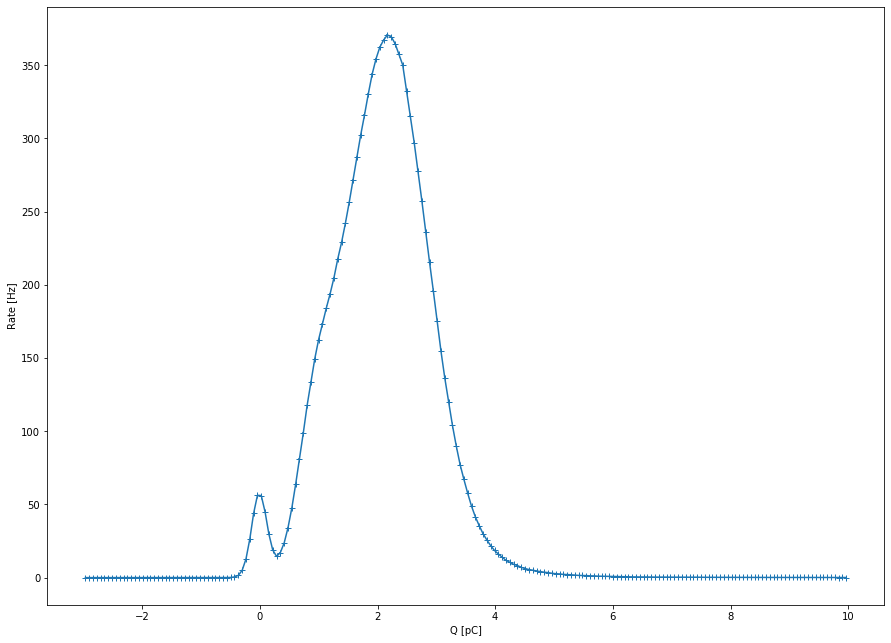

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200317_250_samples_100000_events', 0.2825, 10874.95210294165, 3.4882356577788007]


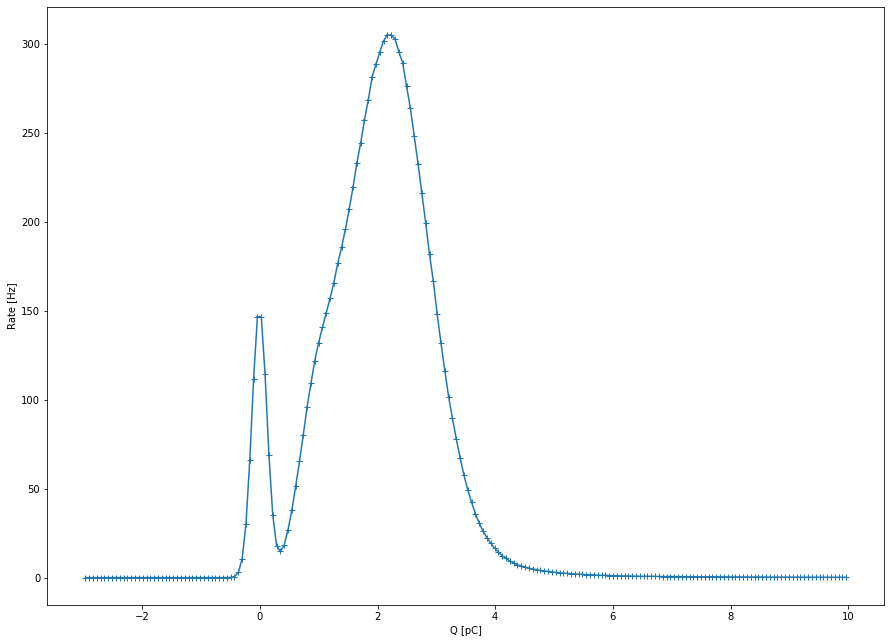

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200318_250_samples_100000_events', 0.3474999999999999, 9001.523294974488, 2.9683015729270217]


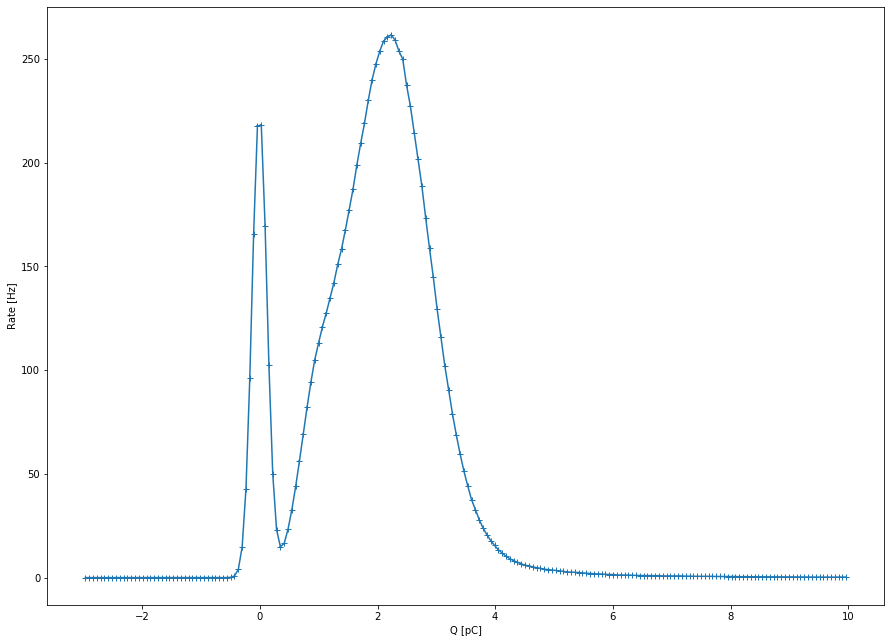

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200319_250_samples_100000_events', 0.3474999999999999, 7801.984730570306, 2.6428557762130818]


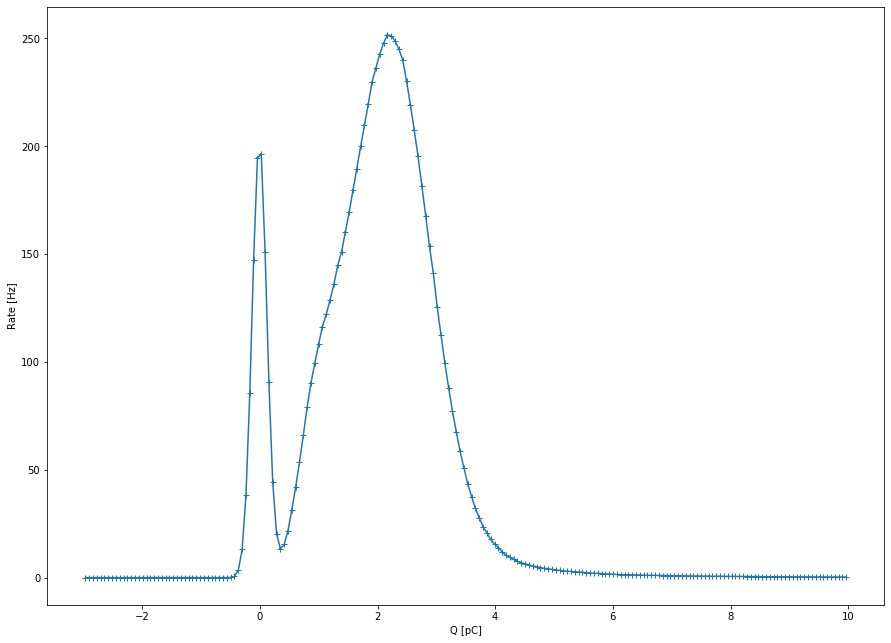

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200320_250_samples_100000_events', 0.3474999999999999, 7523.083618349659, 2.5374653209458233]


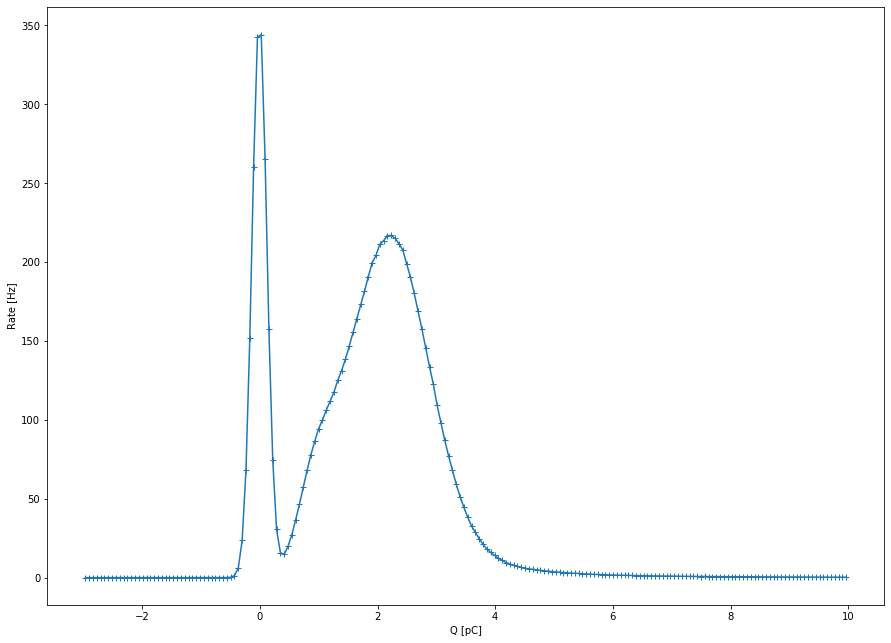

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200321_250_samples_100000_events', 0.4125000000000001, 6536.887489761122, 2.3336160265270047]


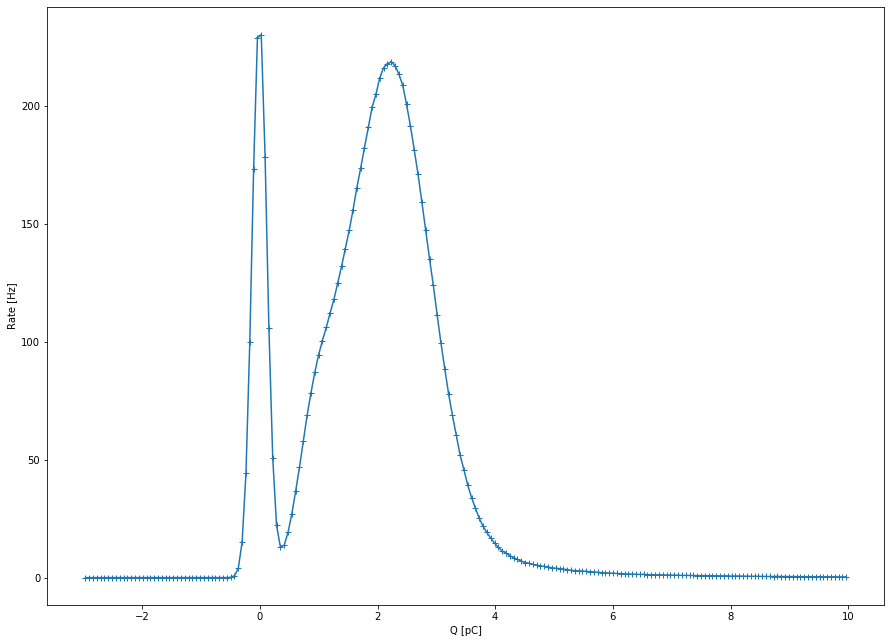

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200322_250_samples_100000_events', 0.3474999999999999, 6616.616195366896, 2.275988982133306]


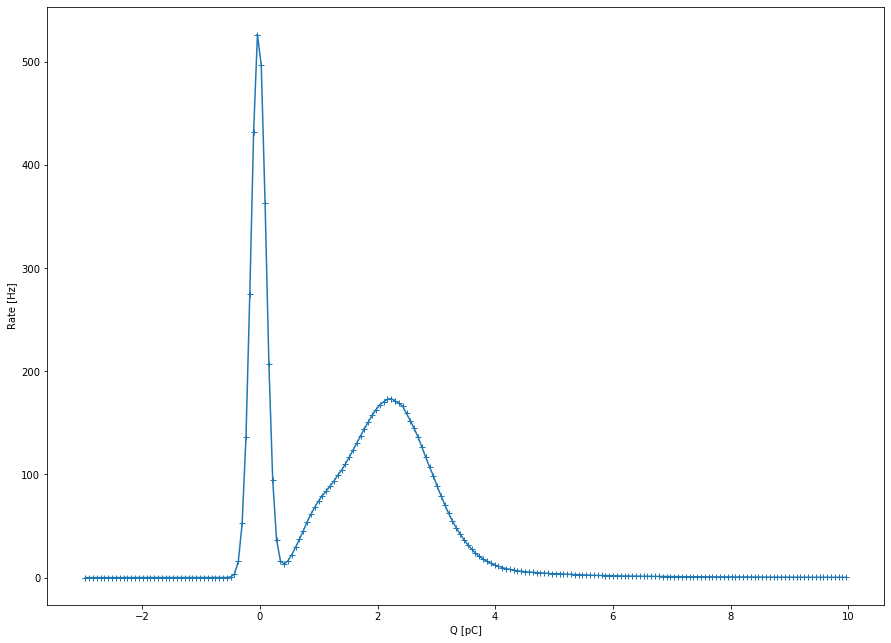

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200323_250_samples_100000_events', 0.4125000000000001, 5269.019073830324, 2.0500353351412004]


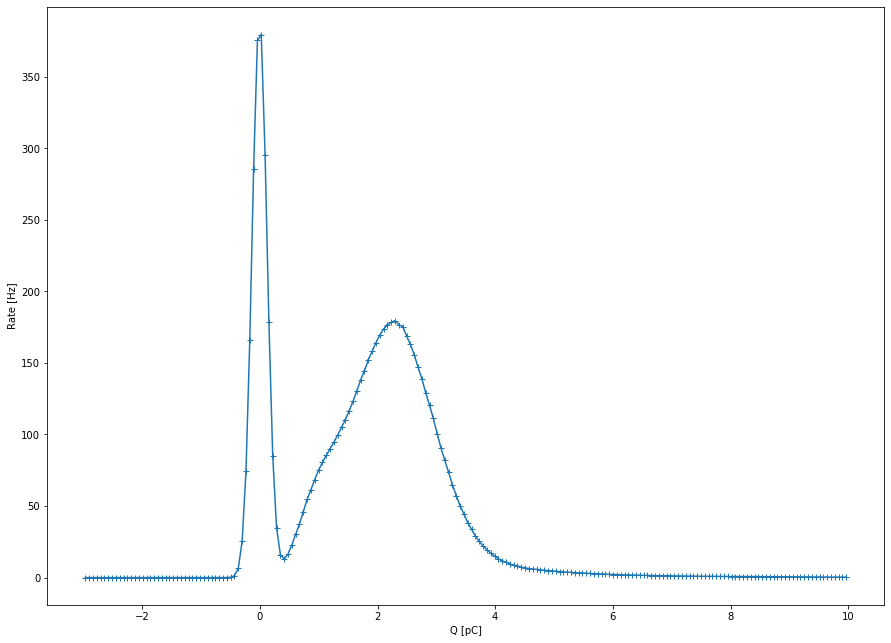

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200403_250_samples_100000_events', 0.4125000000000001, 5567.640956365931, 2.0509711624611713]


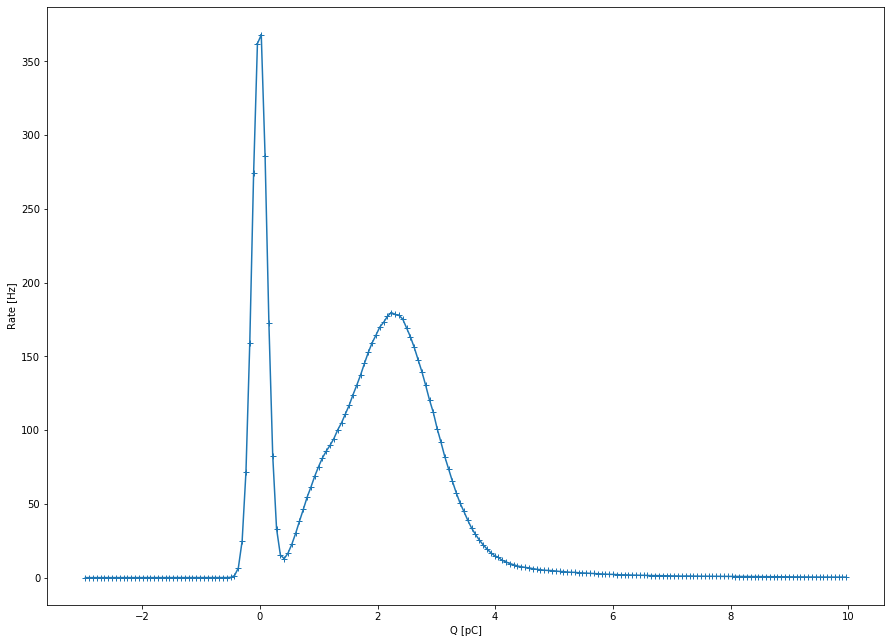

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200404_250_samples_100000_events', 0.4125000000000001, 5581.461252715246, 2.046154972846017]


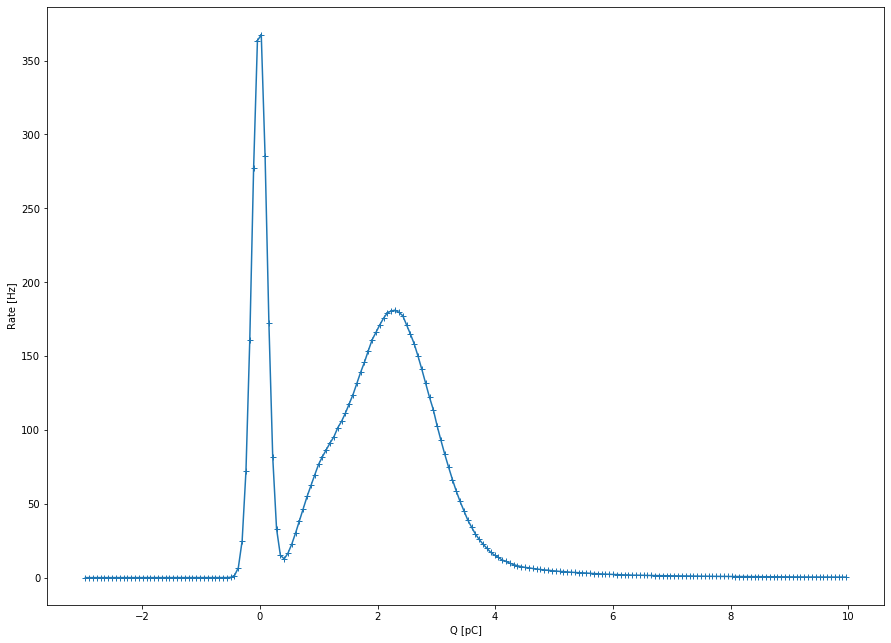

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200405_250_samples_100000_events', 0.4125000000000001, 5641.261547657483, 2.0659143870391565]


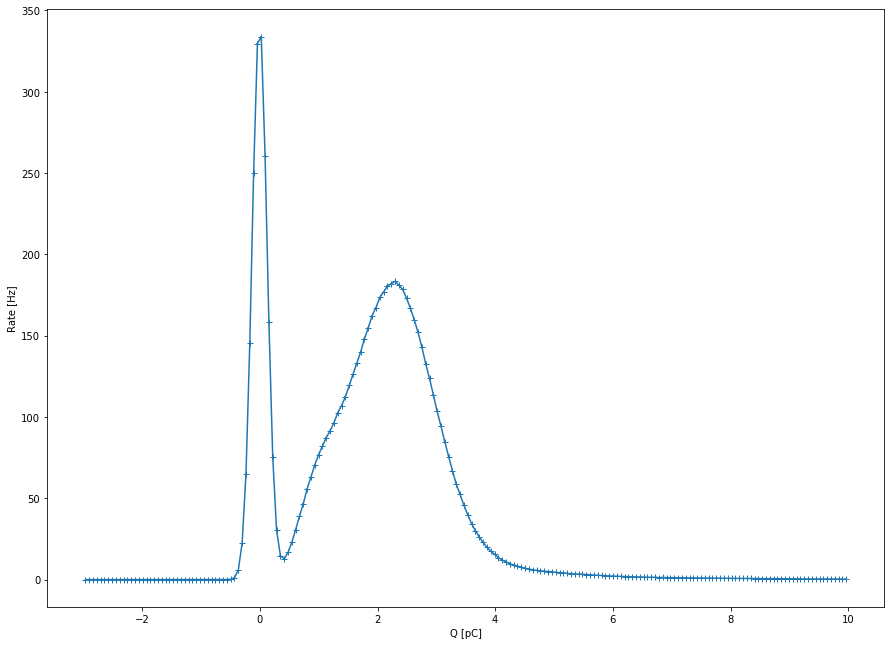

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200406_250_samples_100000_events', 0.4125000000000001, 5699.6693149670755, 2.061396384049429]


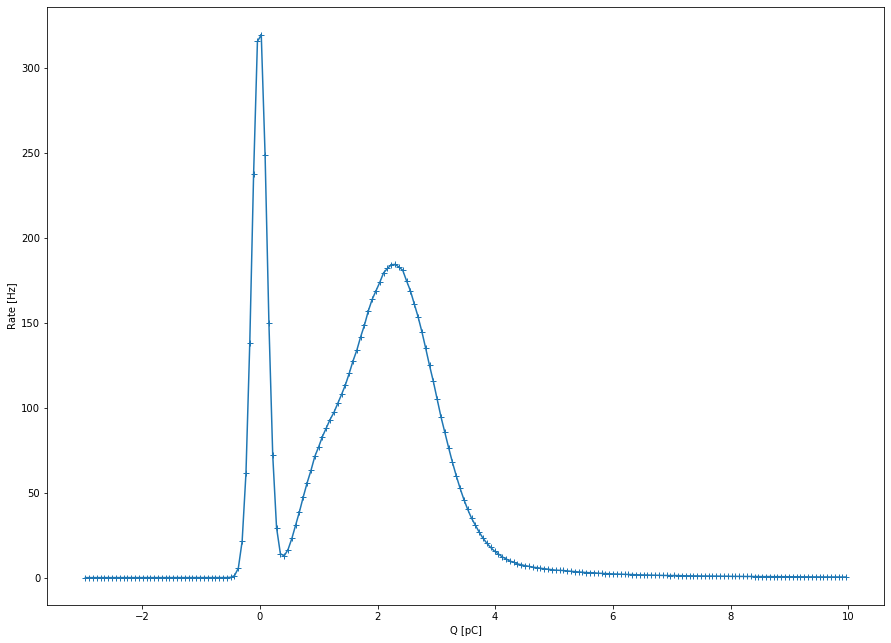

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200407_250_samples_100000_events', 0.4125000000000001, 5749.133748830688, 2.0664204888676956]


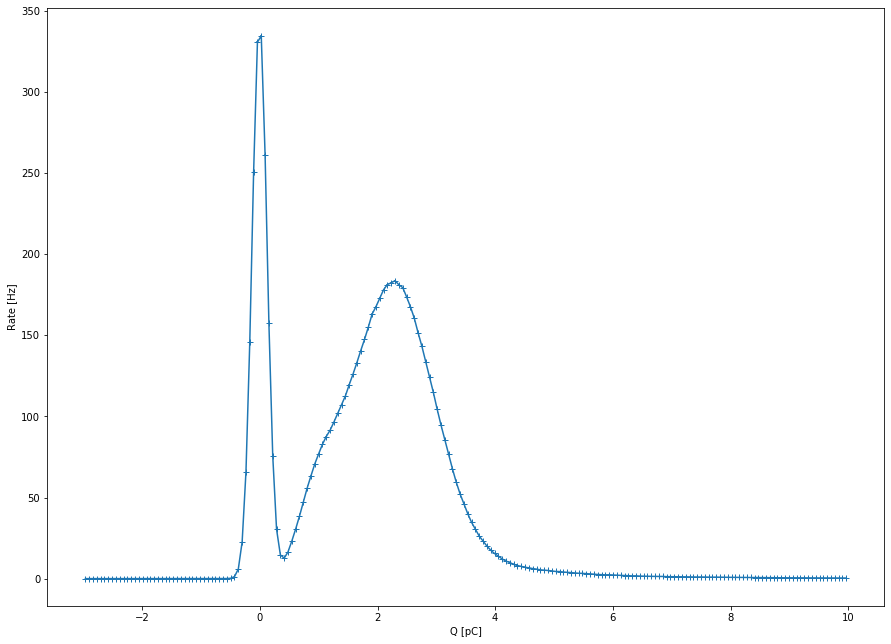

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200408_250_samples_100000_events', 0.4125000000000001, 5716.796592444362, 2.0675931745660834]


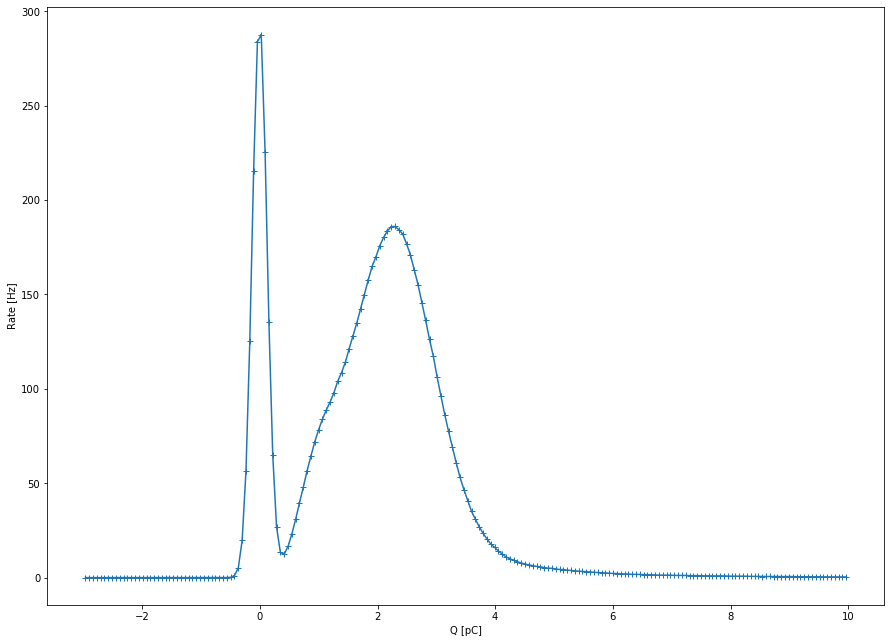

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200409_250_samples_100000_events', 0.4125000000000001, 5807.250502267646, 2.0637818775444514]


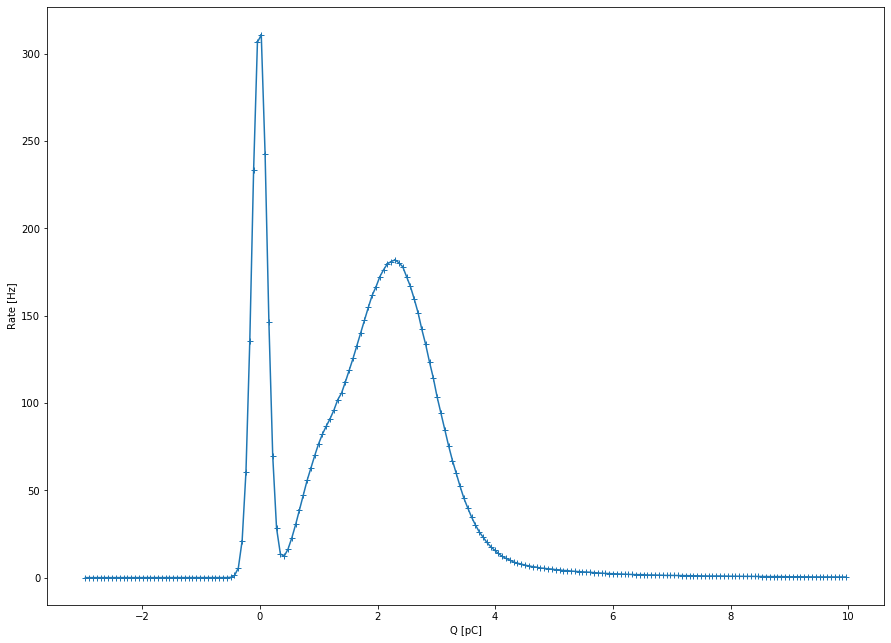

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200410_250_samples_100000_events', 0.4125000000000001, 5686.76492916033, 2.04135149696665]


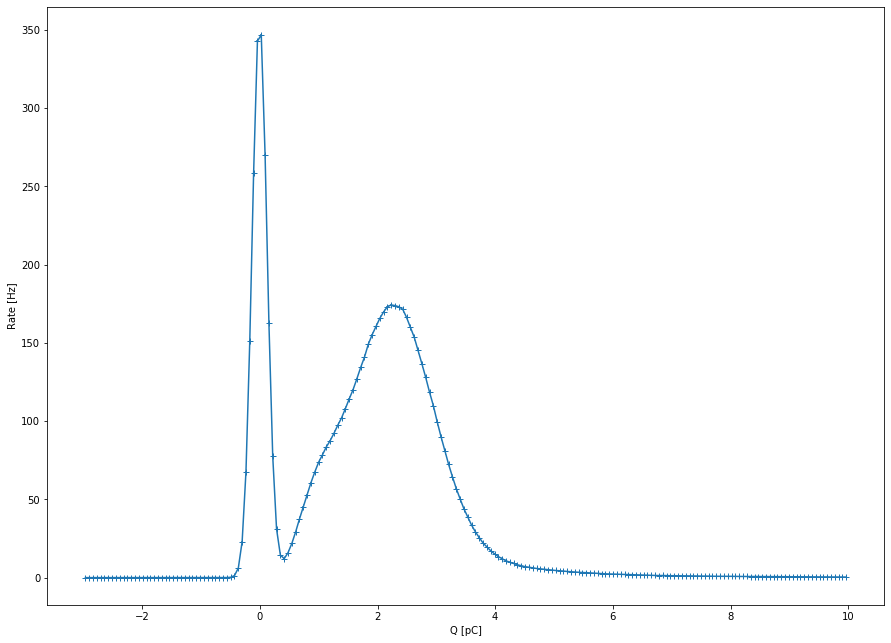

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200411_250_samples_100000_events', 0.4125000000000001, 5472.585742609275, 1.997564505432083]


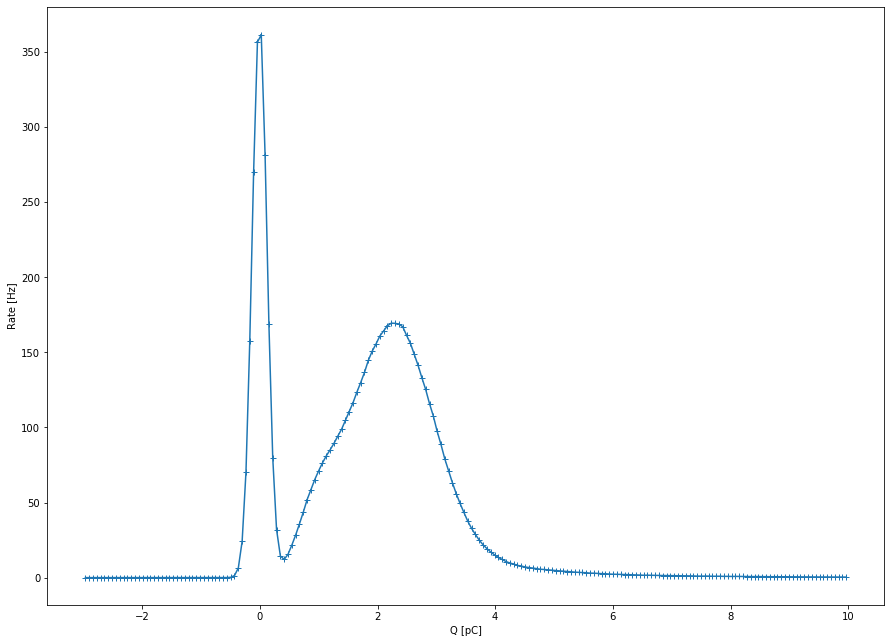

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200412_250_samples_100000_events', 0.4125000000000001, 5332.749973851087, 1.9625364925474558]


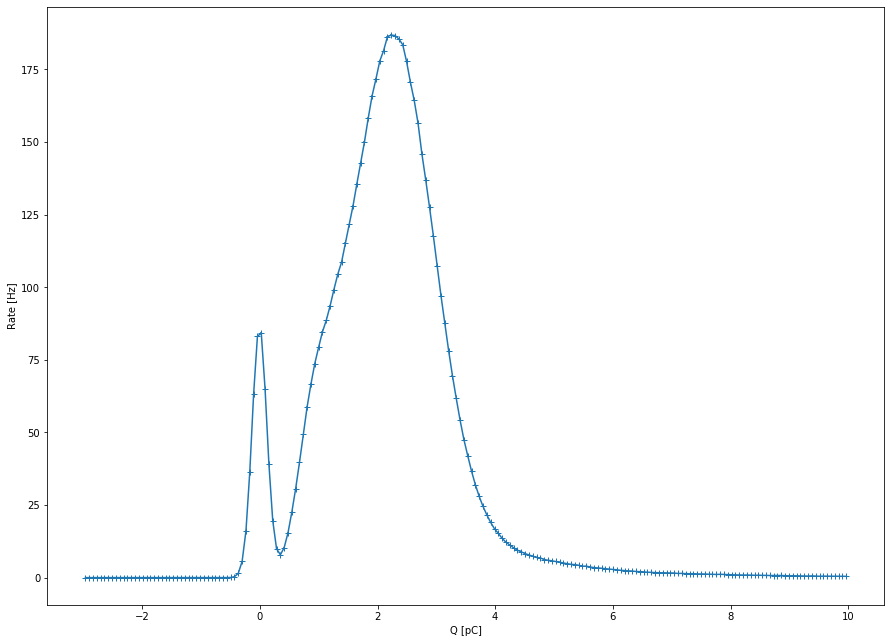

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200415_250_samples_100000_events', 0.3474999999999999, 5901.534493579035, 1.9442966569116122]


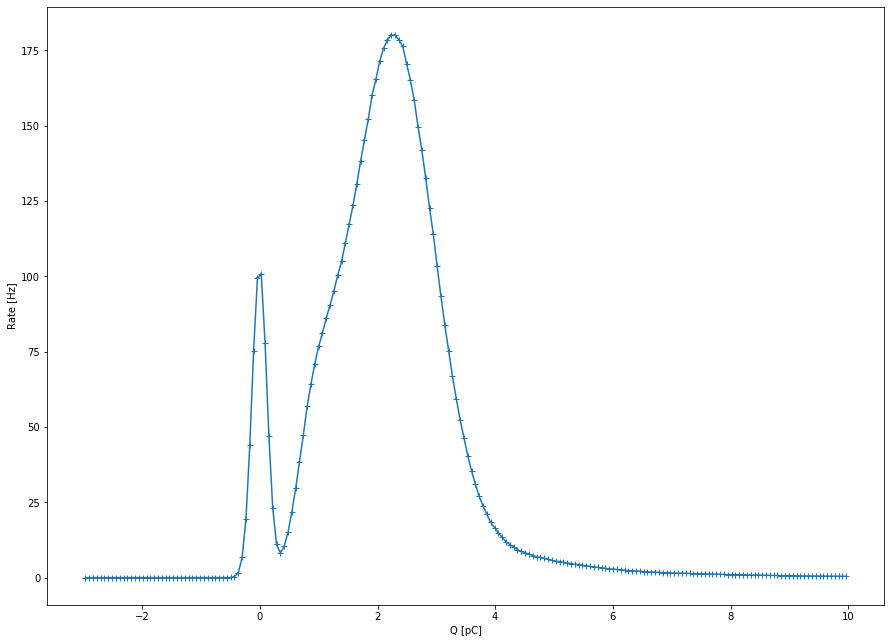

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200416_250_samples_100000_events', 0.3474999999999999, 5702.231031262723, 1.8937281946495377]


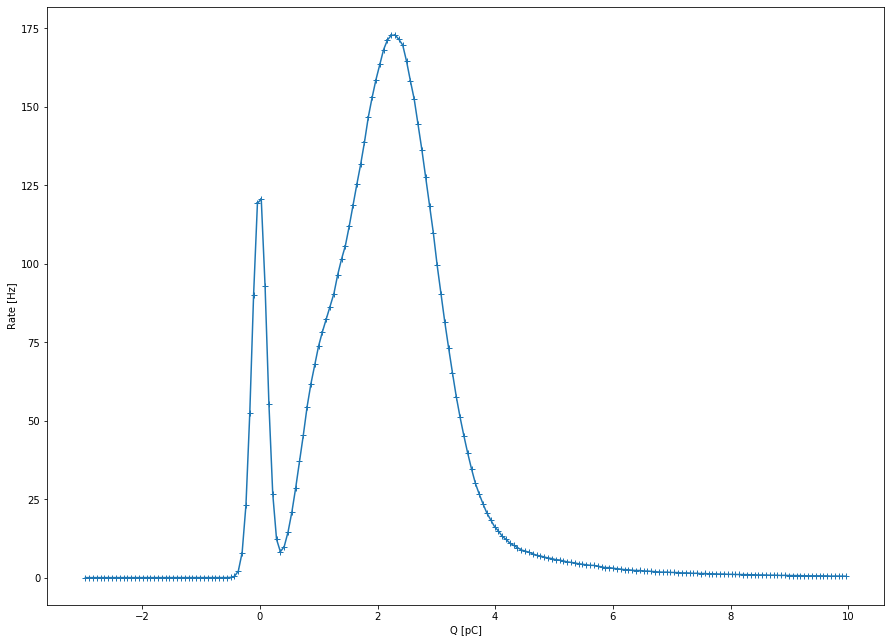

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200417_250_samples_100000_events', 0.3474999999999999, 5503.348845156472, 1.8458245081369826]


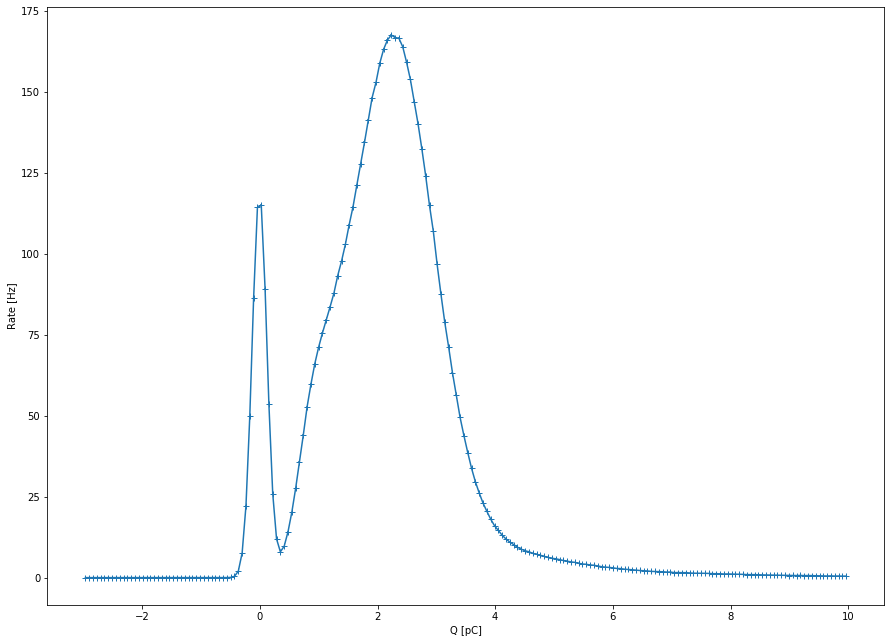

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200419_250_samples_100000_events', 0.3474999999999999, 5343.980421943118, 1.7916890787608275]


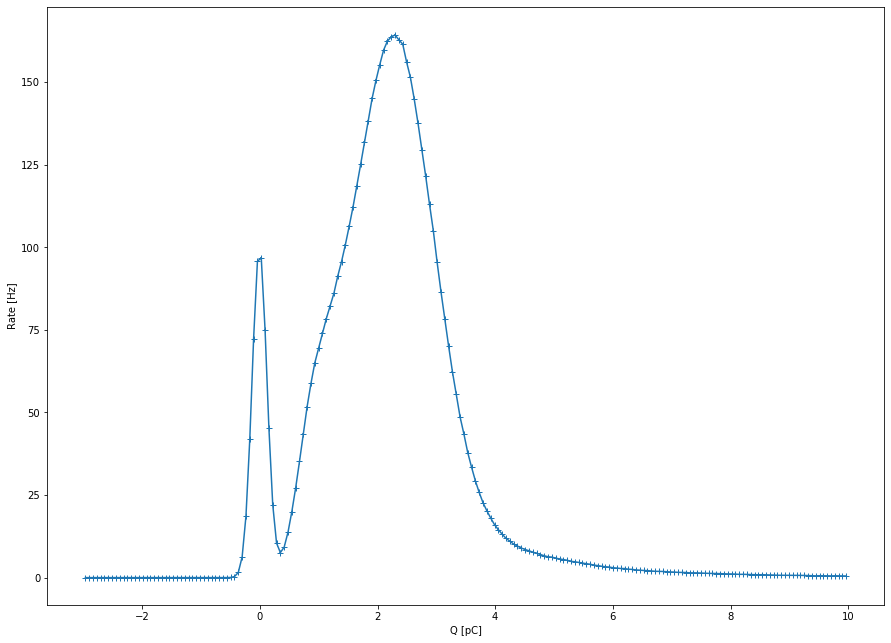

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200420_250_samples_100000_events', 0.3474999999999999, 5254.298902450242, 1.7497940501940041]


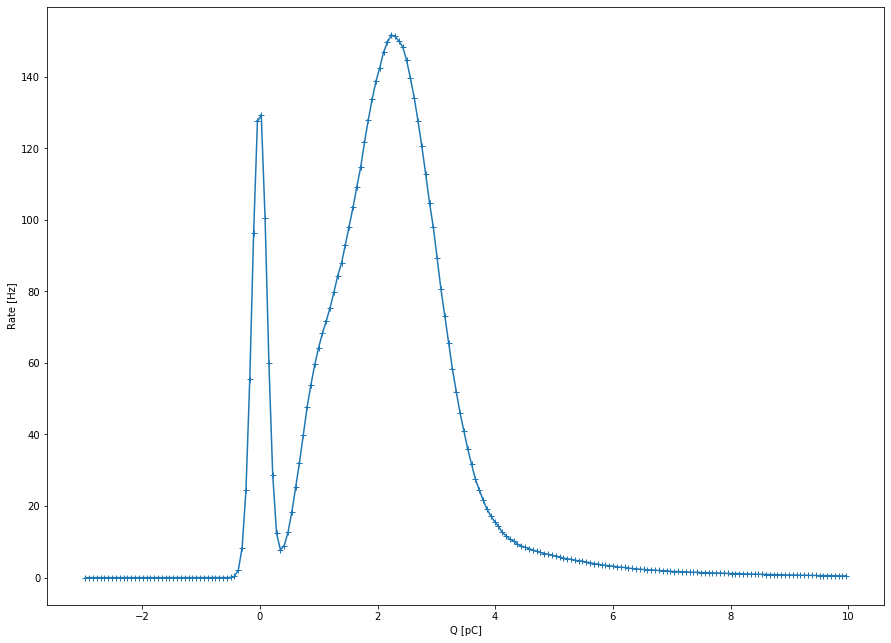

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200424_250_samples_100000_events', 0.3474999999999999, 4887.72356215999, 1.6576261133883314]


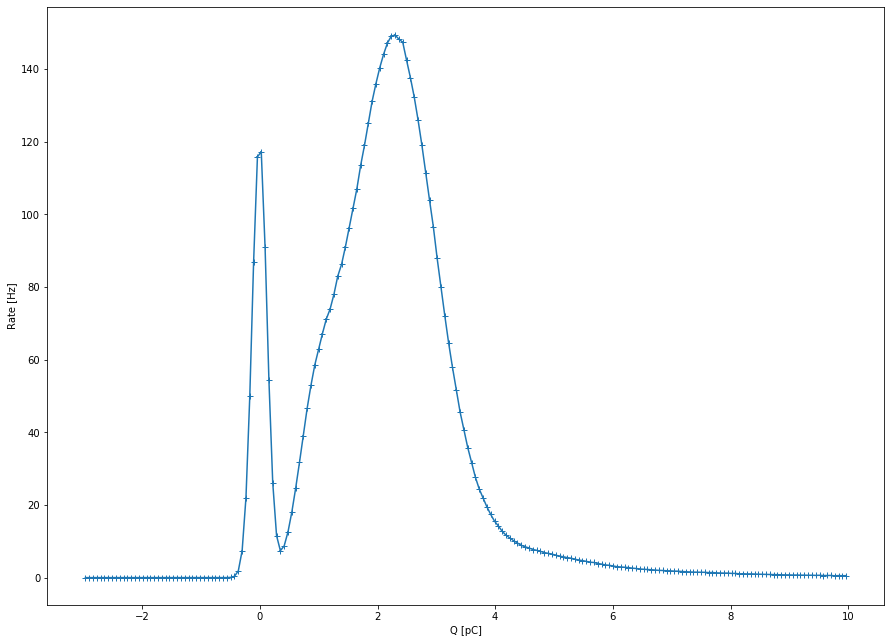

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200425_250_samples_100000_events', 0.3474999999999999, 4826.212003869807, 1.6293028882382494]


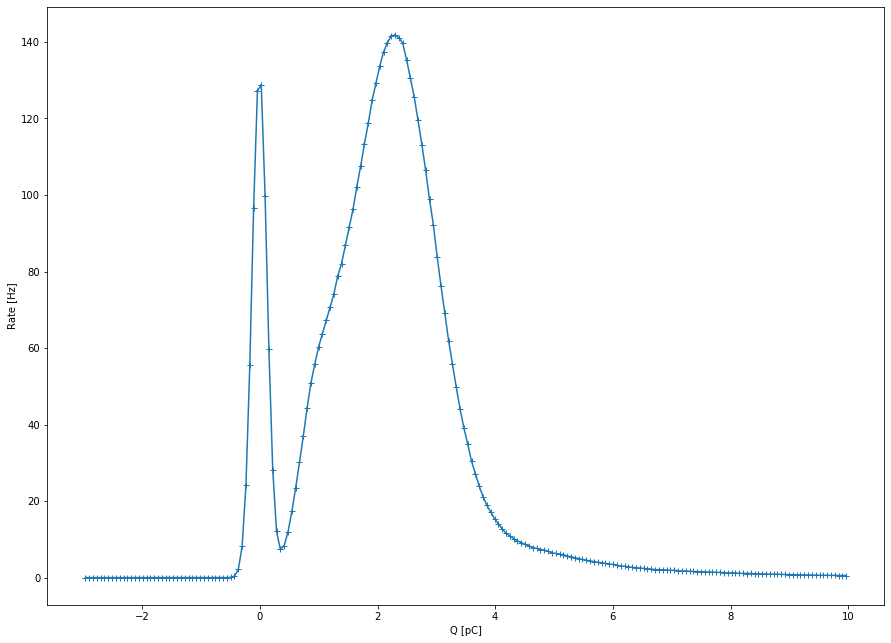

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200428_250_samples_100000_events', 0.3474999999999999, 4621.355601643888, 1.5732907063191848]


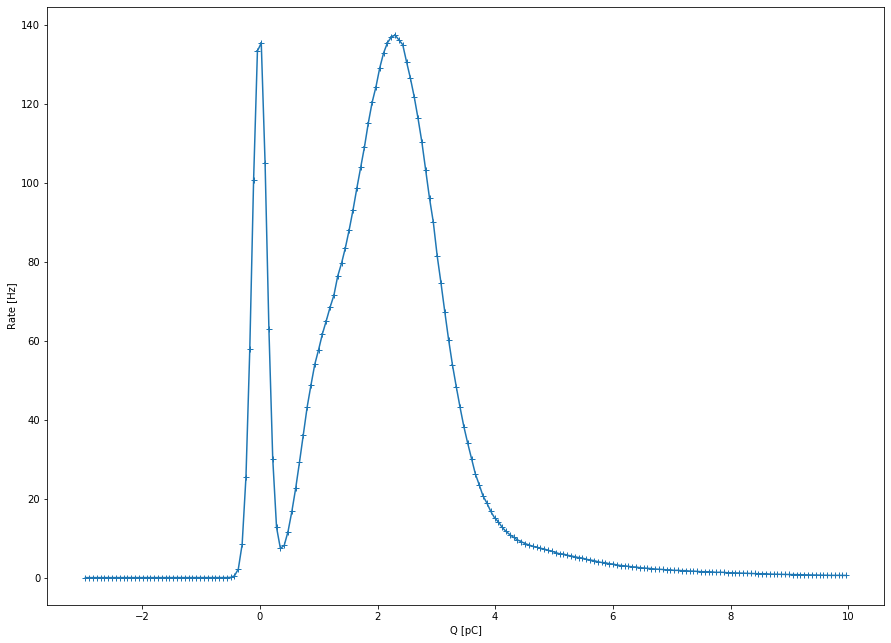

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200430_250_samples_100000_events', 0.3474999999999999, 4488.2009701074685, 1.5358889198551564]


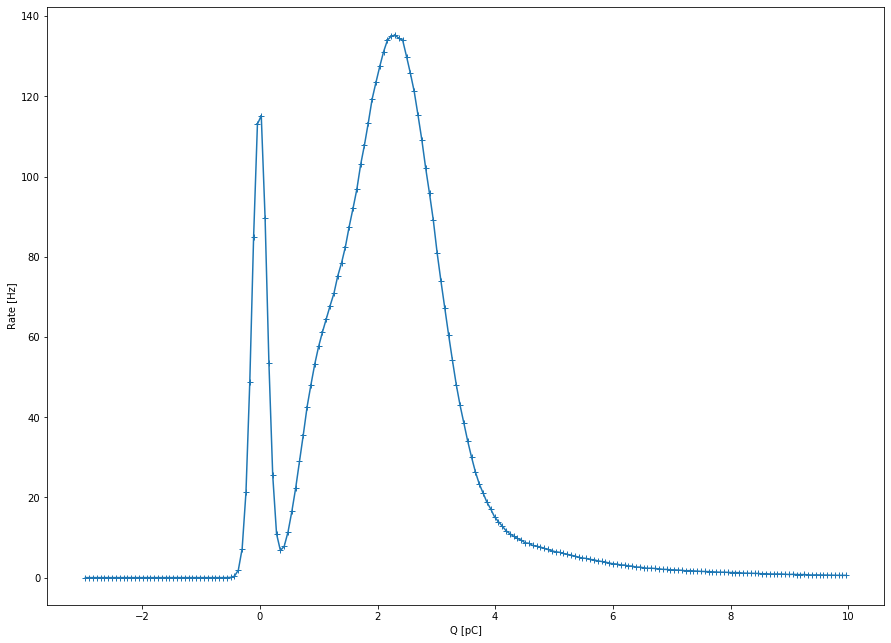

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200501_250_samples_100000_events', 0.3474999999999999, 4454.506536990951, 1.5106341772303222]


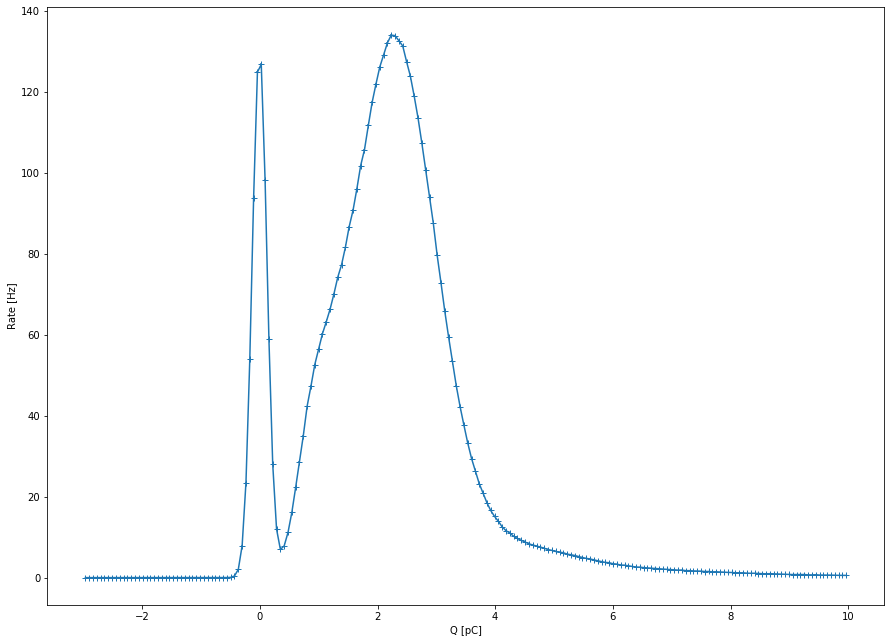

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200502_250_samples_100000_events', 0.3474999999999999, 4392.937845162513, 1.4995333156518222]


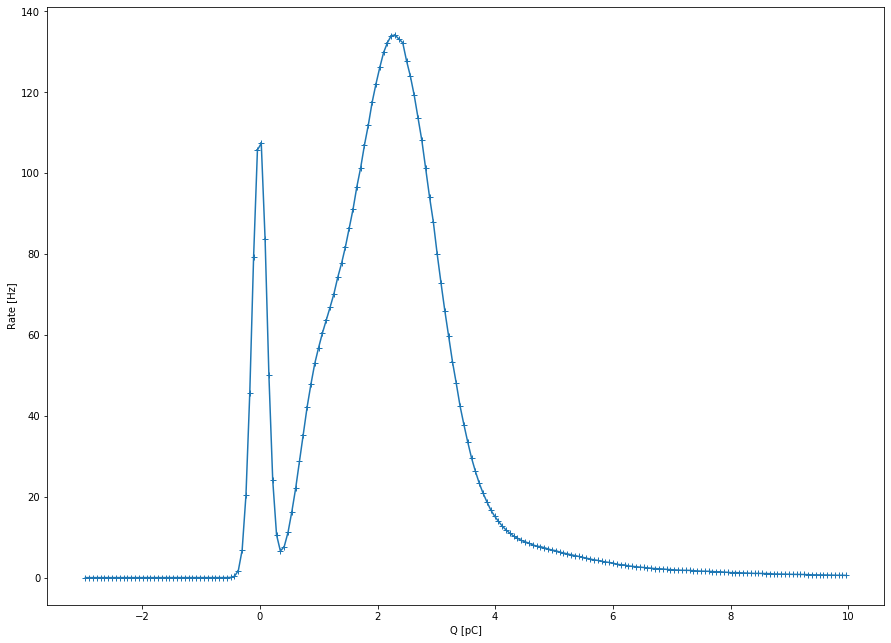

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200503_250_samples_100000_events', 0.3474999999999999, 4408.946512373176, 1.4909860368445267]


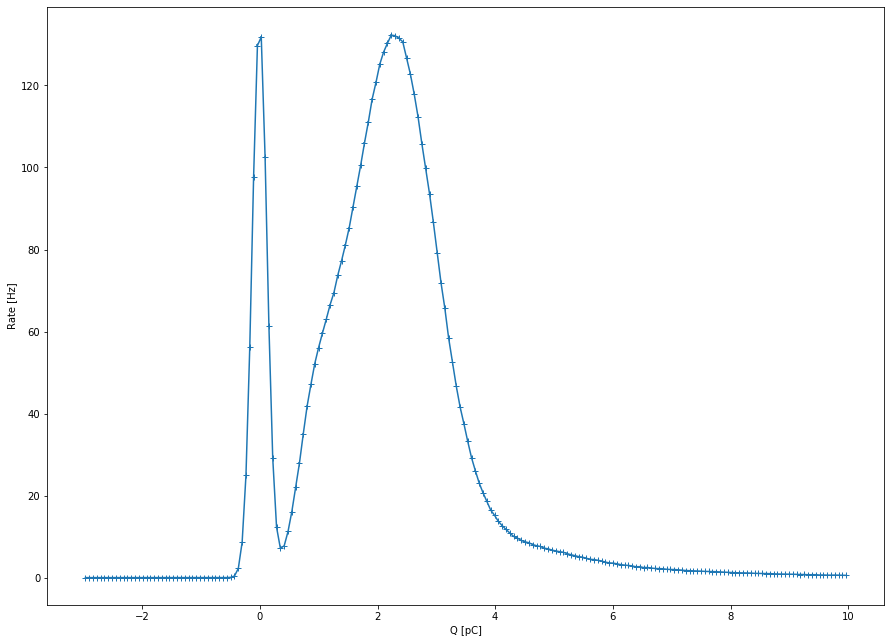

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200504_250_samples_100000_events', 0.3474999999999999, 4360.854238902502, 1.4932328047921948]


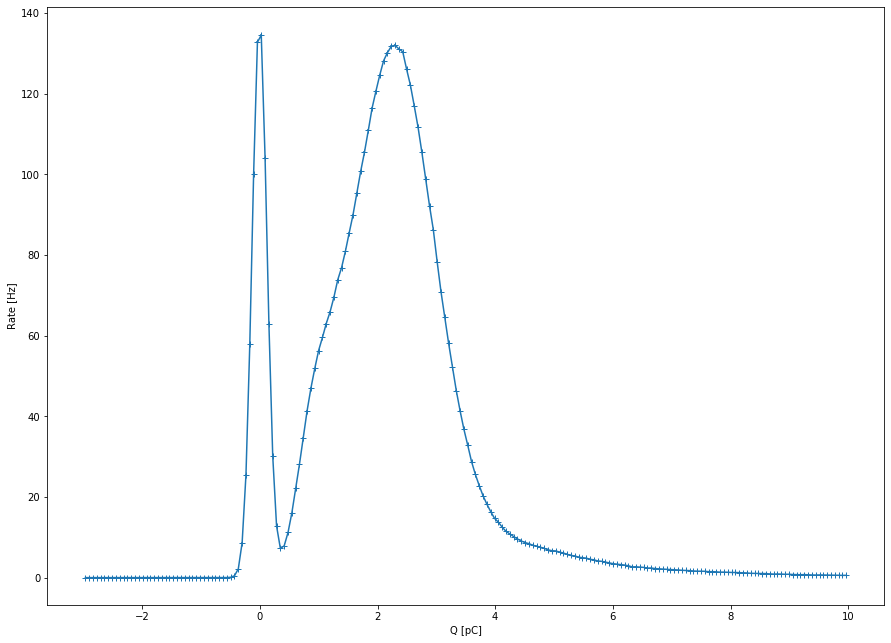

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200505_250_samples_100000_events', 0.3474999999999999, 4341.728615786167, 1.4895074819116705]


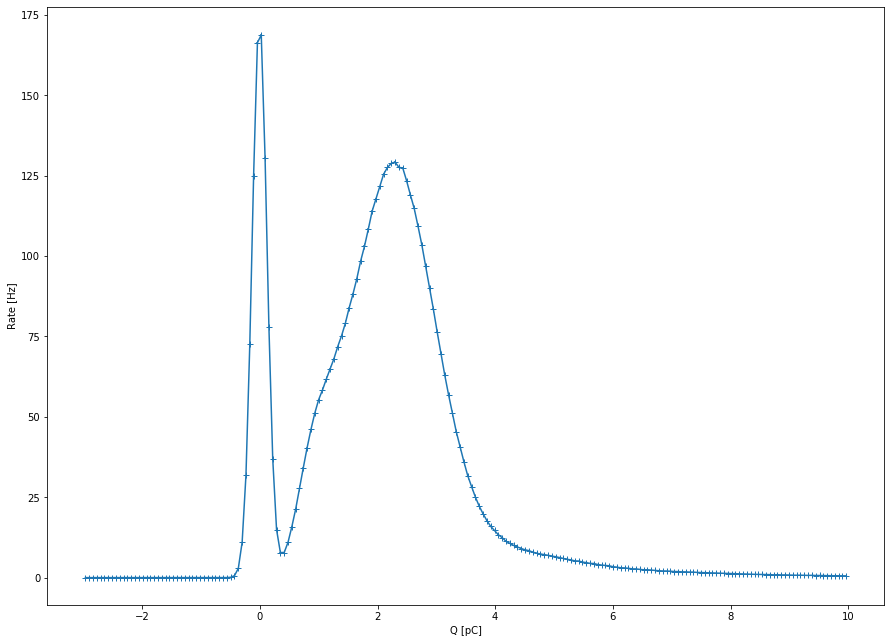

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200506_250_samples_100000_events', 0.4125000000000001, 4242.155995994108, 1.4829557851181119]


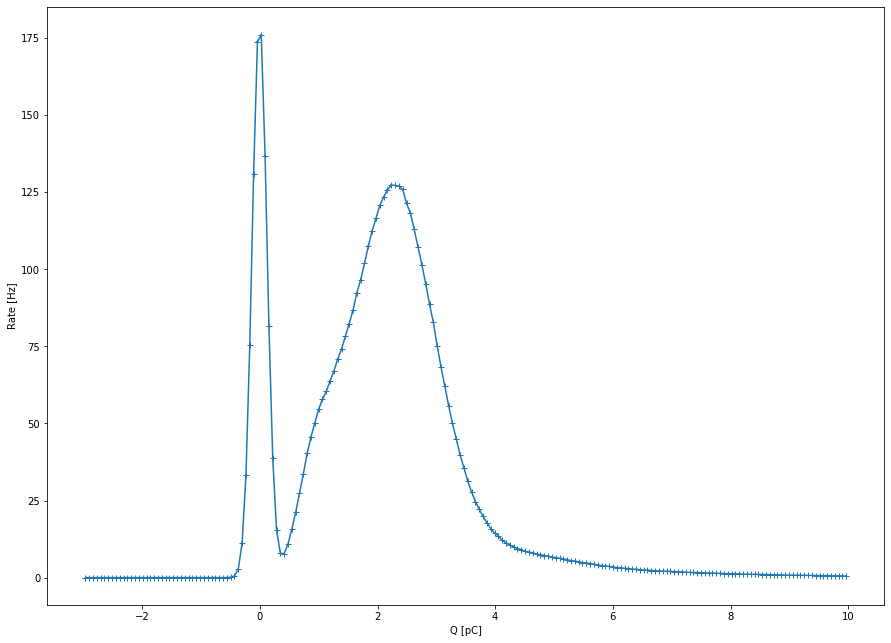

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200508_250_samples_100000_events', 0.4125000000000001, 4189.610716503059, 1.471323874781452]


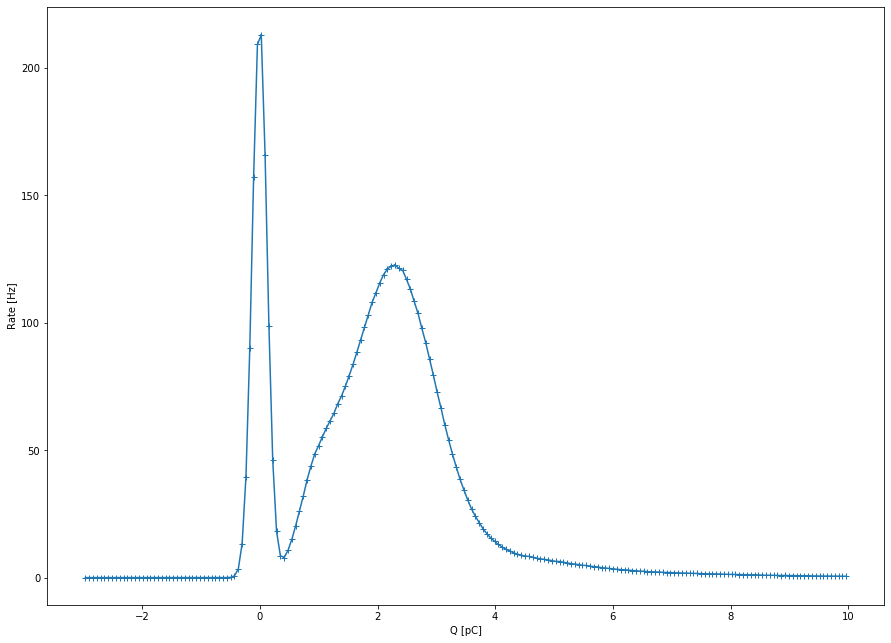

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200510_250_samples_100000_events', 0.4125000000000001, 4043.3723626560572, 1.4503462324055816]


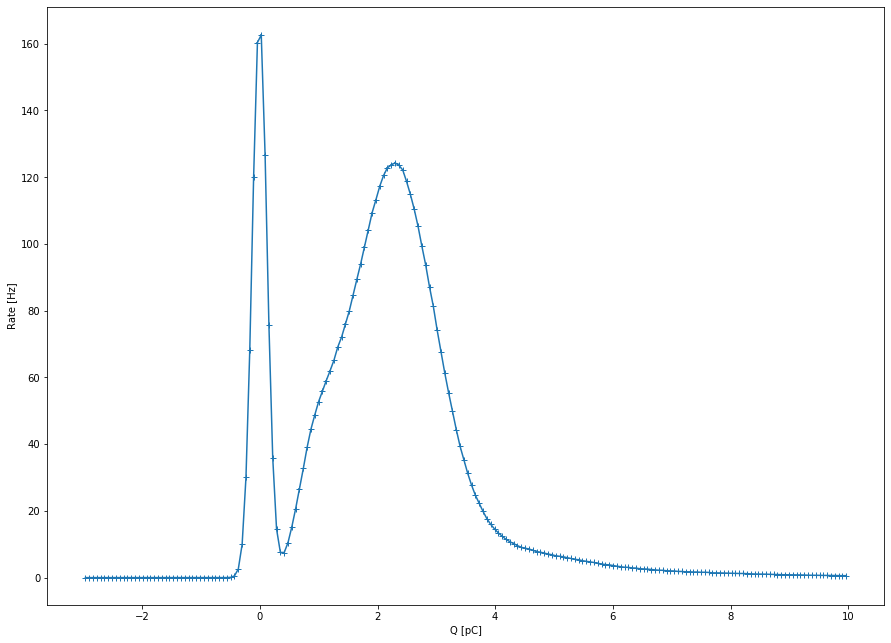

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200511_250_samples_100000_events', 0.4125000000000001, 4108.895737573515, 1.4364805594066912]


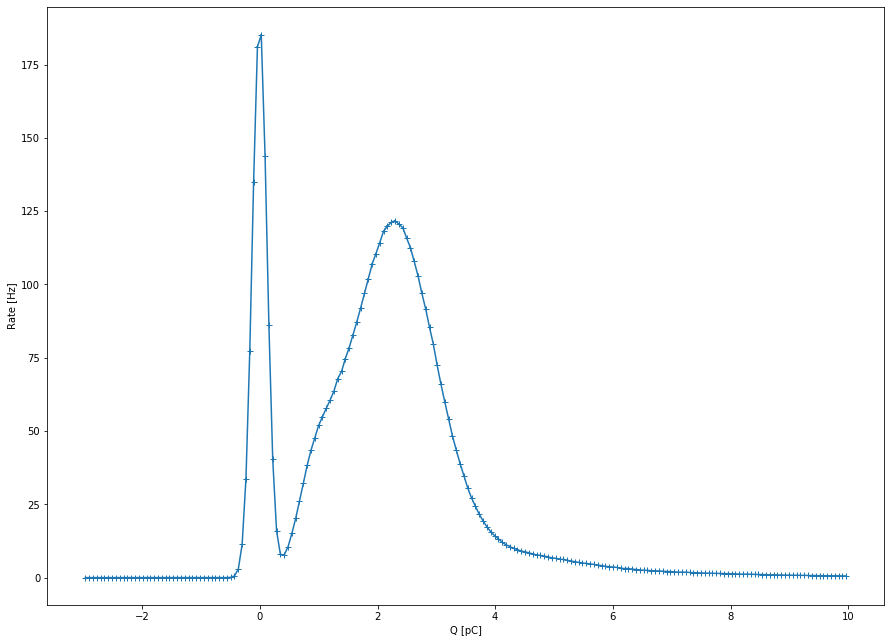

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200512_250_samples_100000_events', 0.4125000000000001, 4024.1277440958097, 1.4245195062929799]


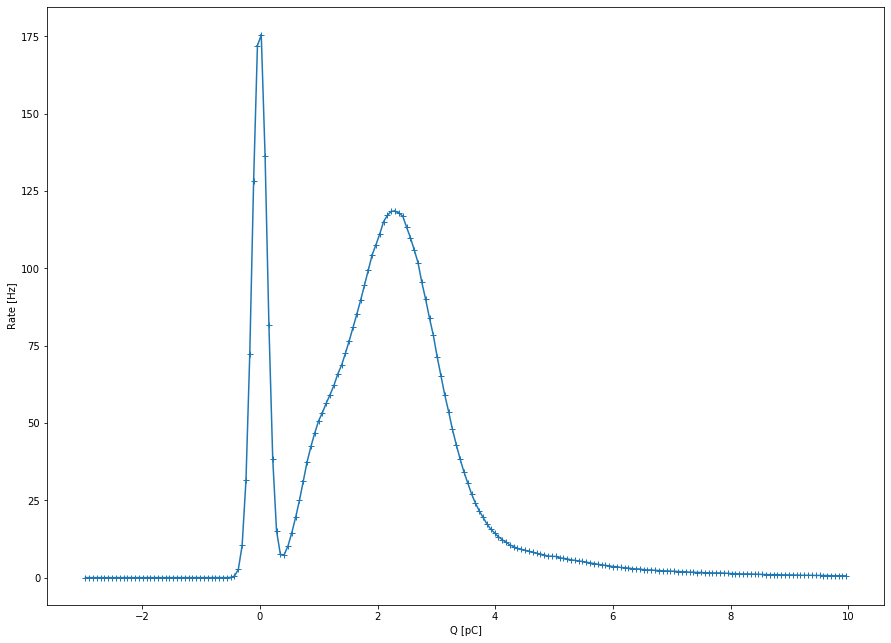

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200513_250_samples_100000_events', 0.4125000000000001, 3951.7724056066345, 1.394631822550761]


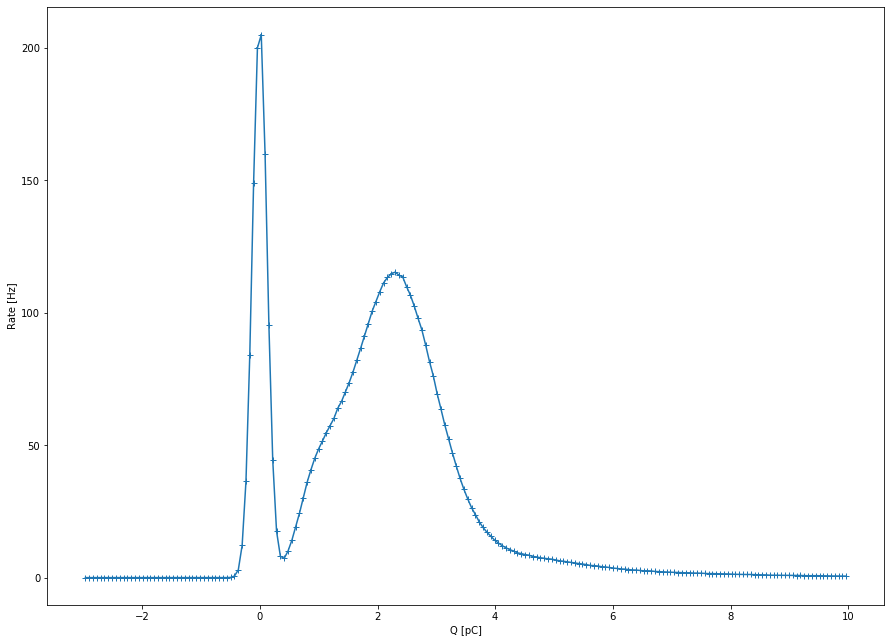

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200514_250_samples_100000_events', 0.4125000000000001, 3839.0076780373415, 1.3787829952501711]


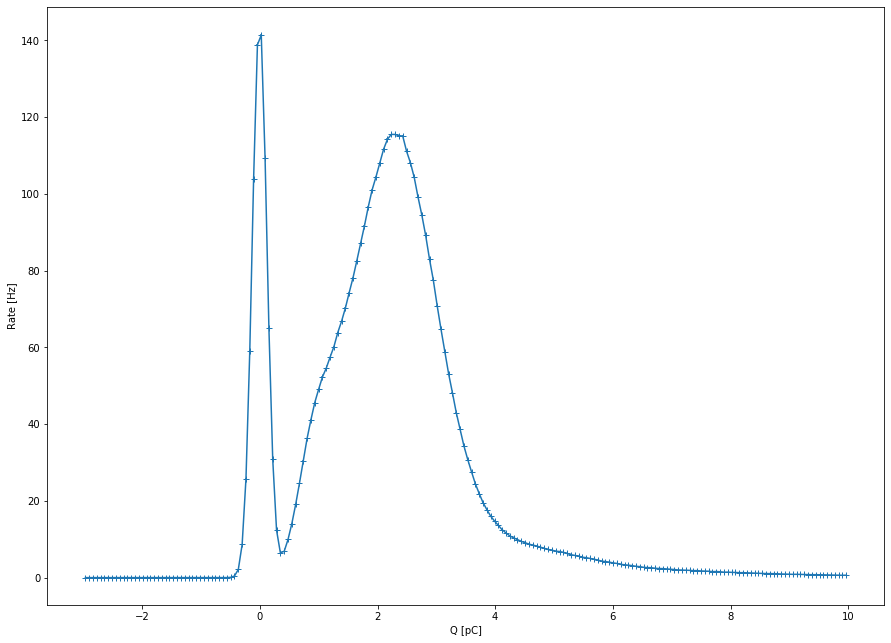

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200515_250_samples_100000_events', 0.3474999999999999, 3897.20376008081, 1.3529924305189622]


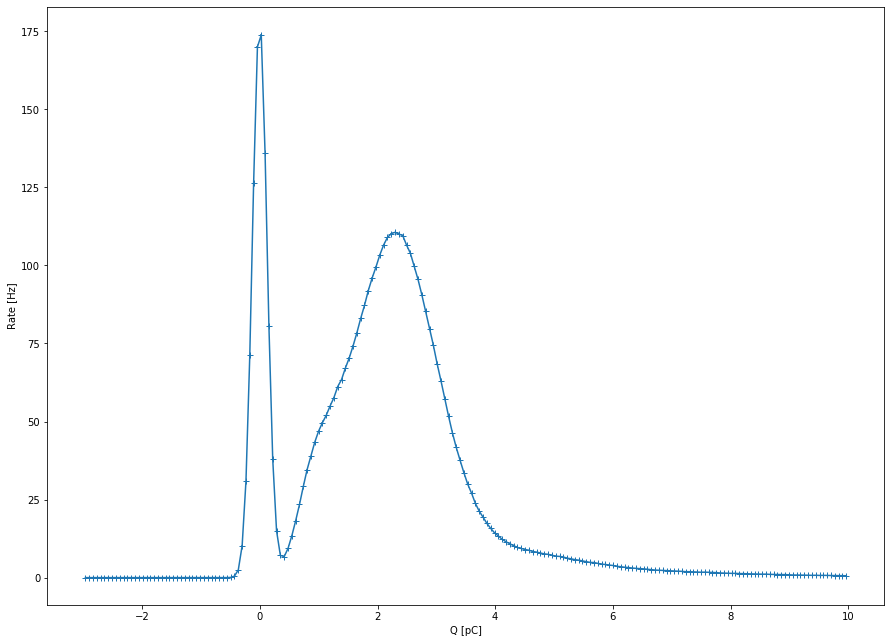

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200517_250_samples_100000_events', 0.4125000000000001, 3739.091942052553, 1.325945446617413]


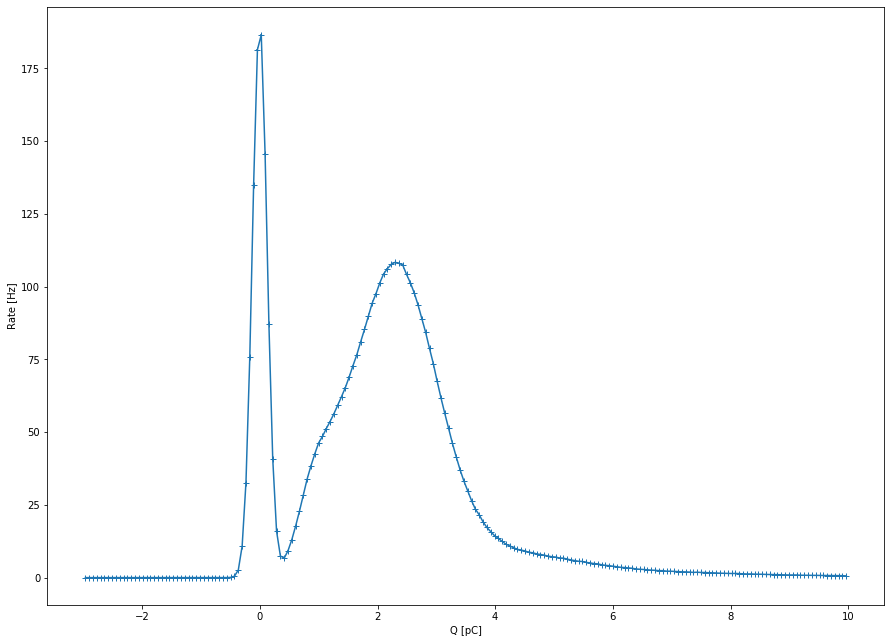

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200518_250_samples_100000_events', 0.4125000000000001, 3678.8107890539354, 1.3151948017655009]


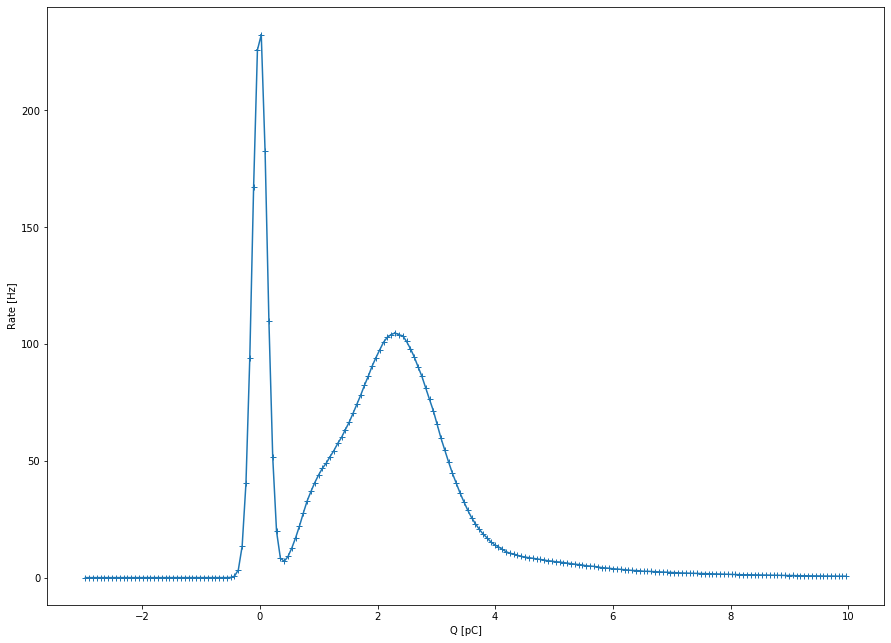

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200519_250_samples_100000_events', 0.4125000000000001, 3560.7483564158515, 1.3086985175966355]


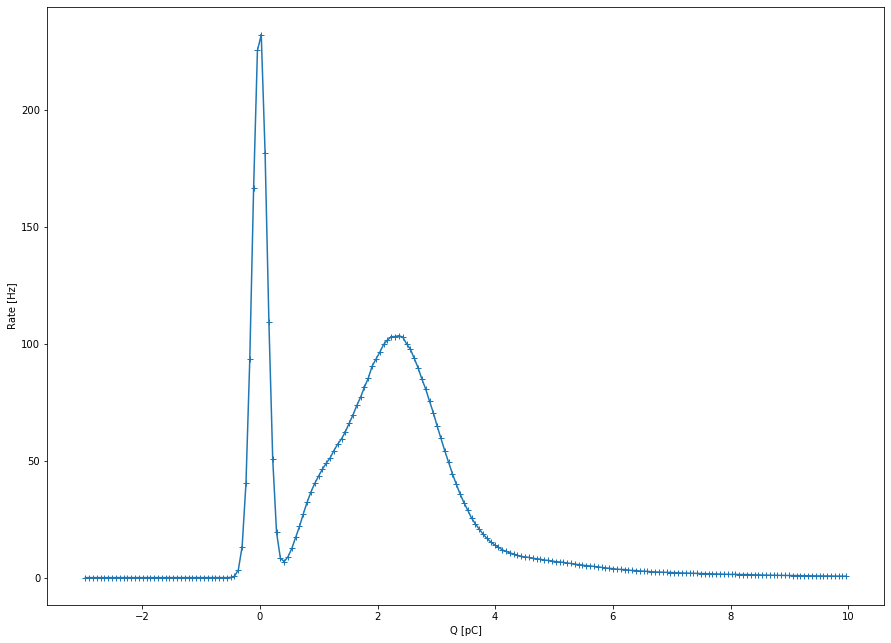

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200520_250_samples_100000_events', 0.4125000000000001, 3532.298026021535, 1.2988030077335506]


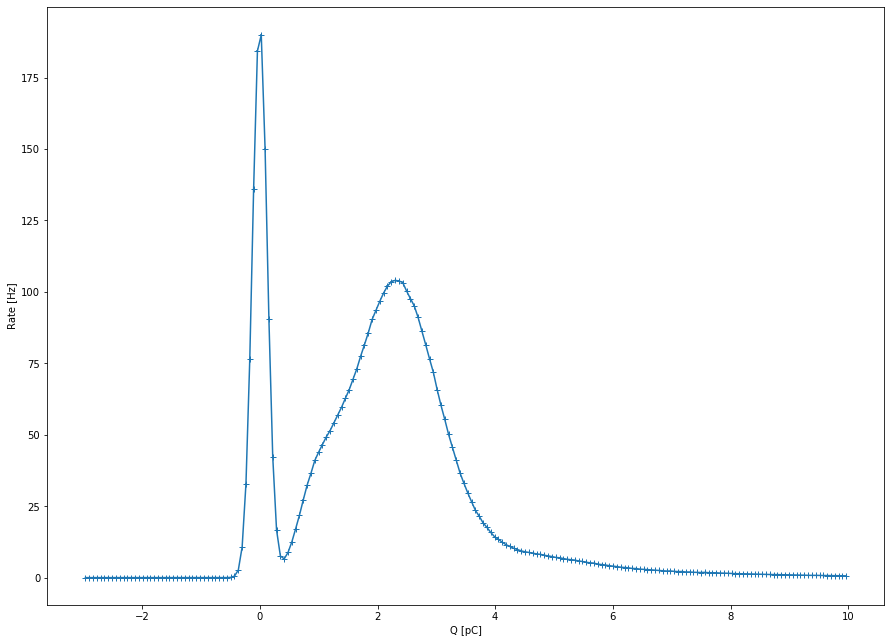

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200522_250_samples_100000_events', 0.4125000000000001, 3569.70894187203, 1.2834400741629195]


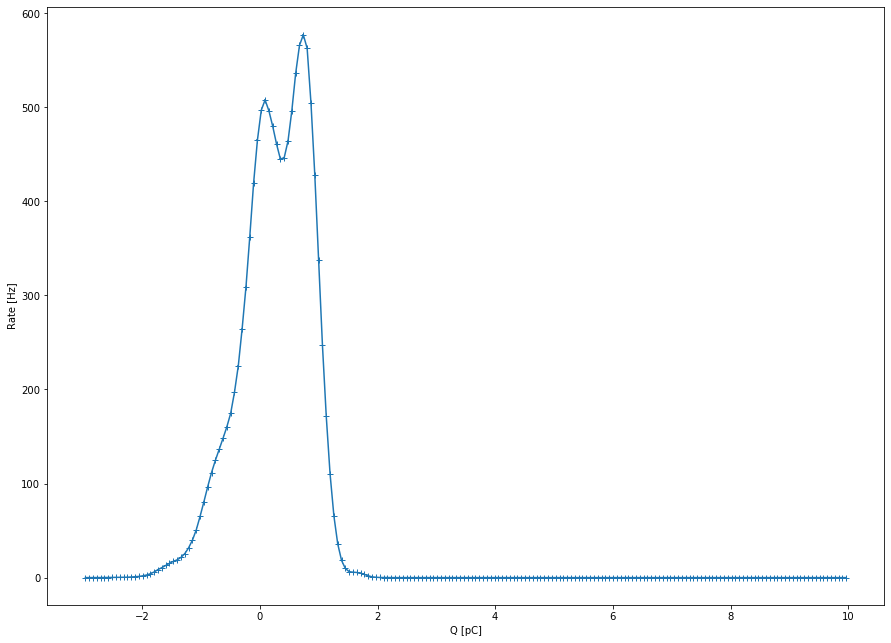

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200529_250_samples_100000_events', 1.9725000000000001, 0.8183126967005764, 0.03147358592703391]


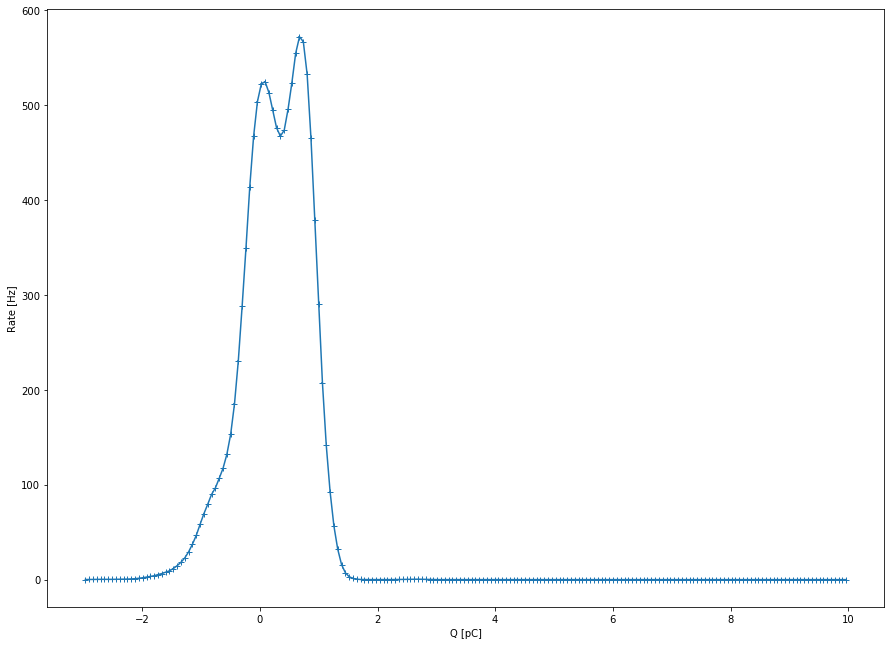

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200530_250_samples_100000_events', 1.9075000000000002, 2.995069324635664, 0.05971082862637308]


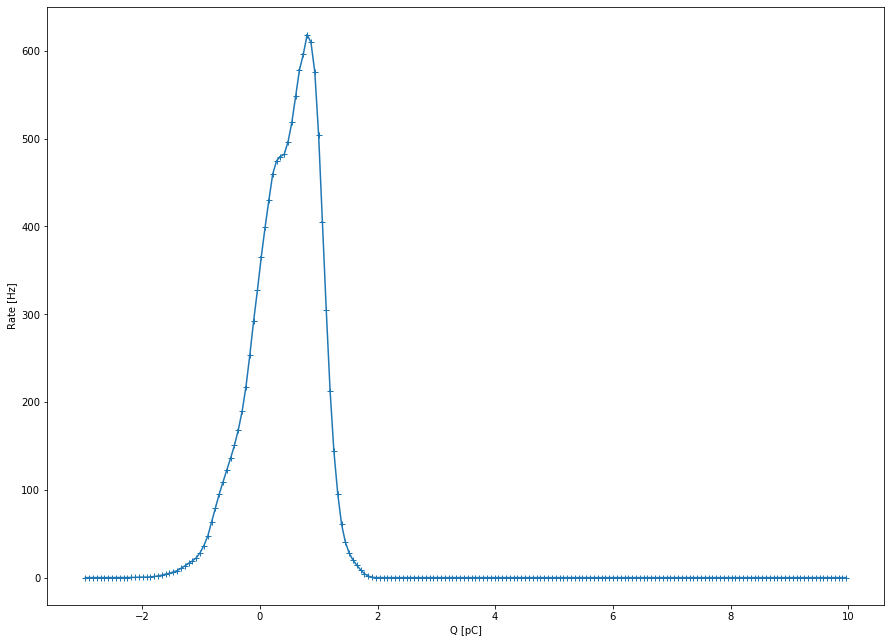

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200531_250_samples_100000_events', 1.9725000000000001, 0.12041089853468487, 0.011981352704072181]


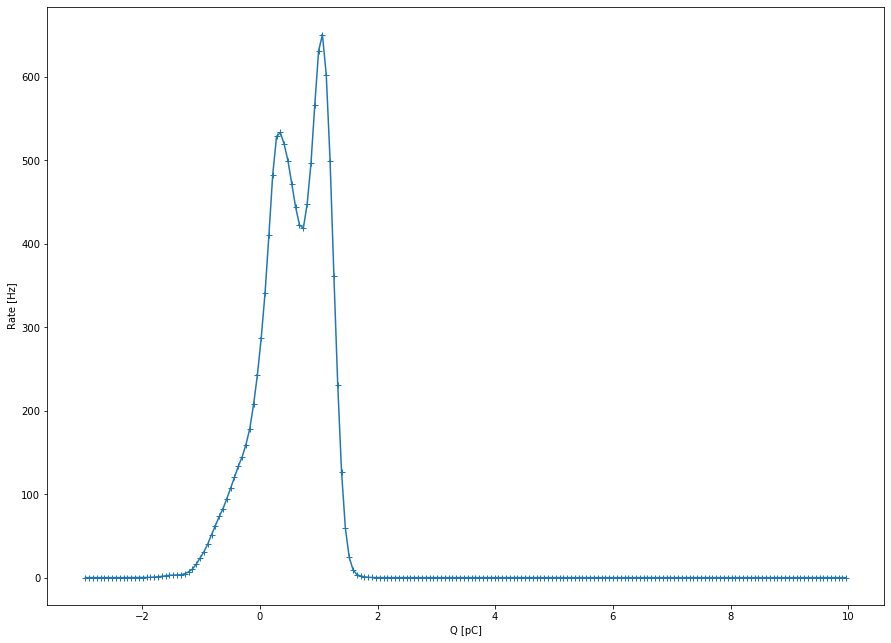

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200601_250_samples_100000_events', 1.9725000000000001, 0.1286309846173761, 0.012377651852127068]


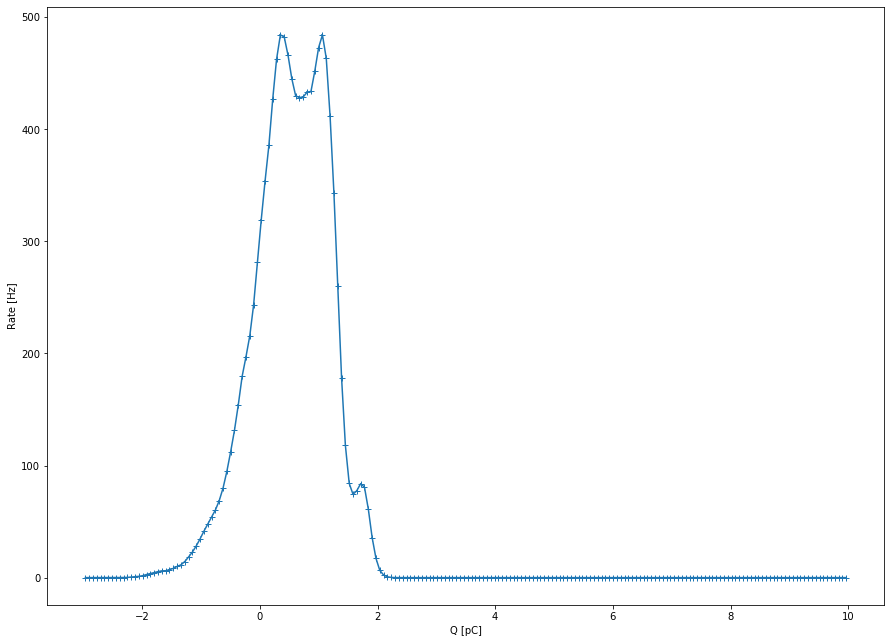

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200602_250_samples_100000_events', 1.9725000000000001, 27.152904465845953, 0.17923995855933605]


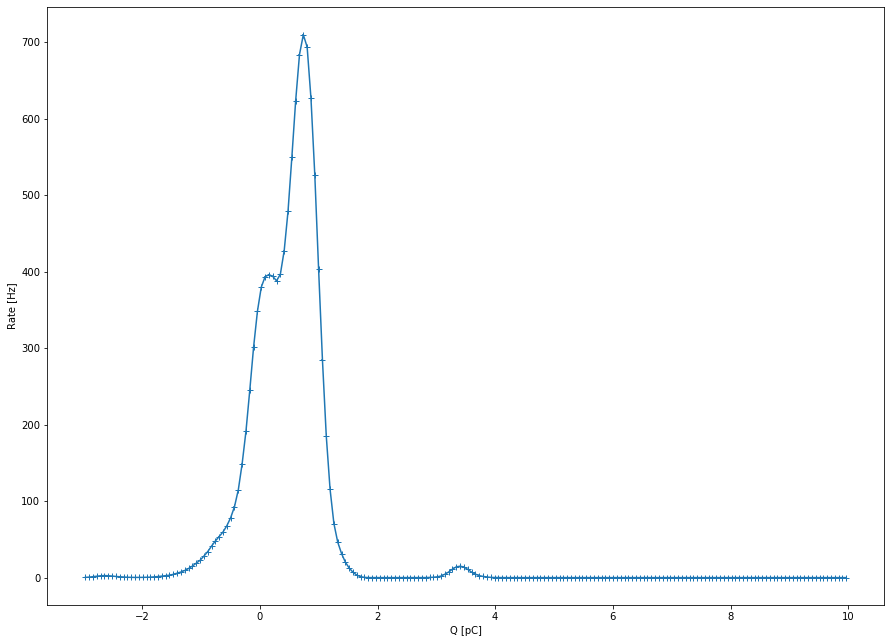

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200603_250_samples_100000_events', 1.9725000000000001, 97.53370810374193, 0.3412547620397426]


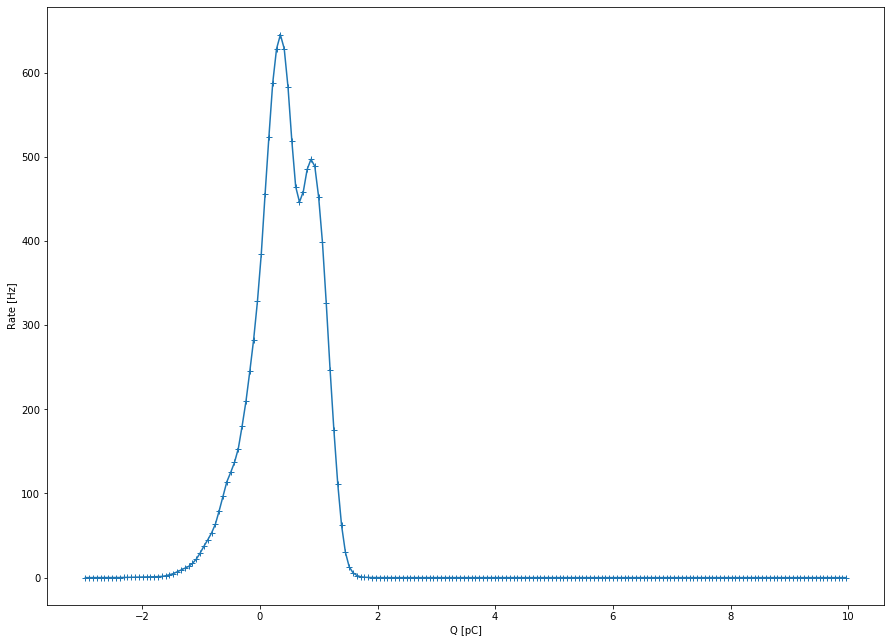

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200604_250_samples_100000_events', 1.9725000000000001, 0.09880943704861157, 0.01084575361799375]


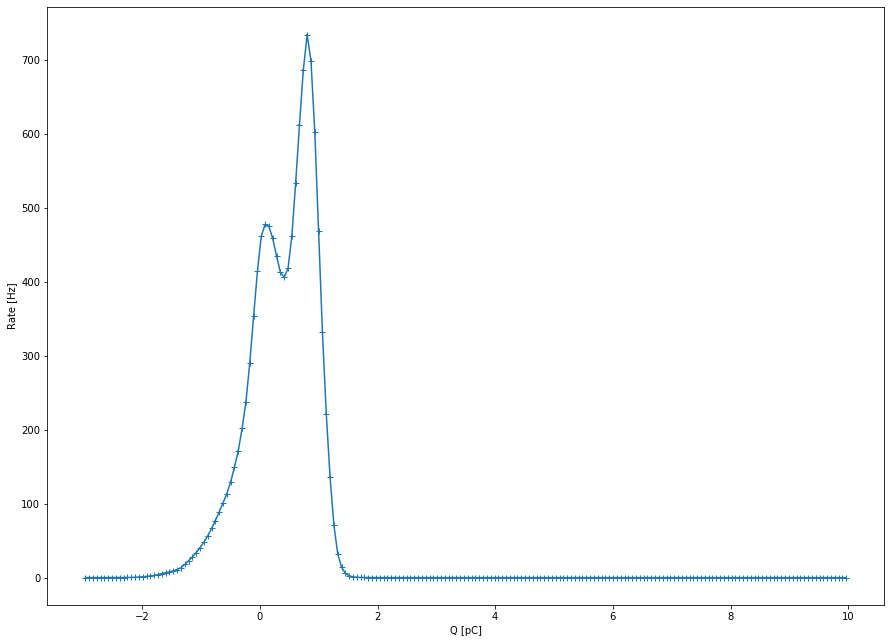

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200606_250_samples_100000_events', 1.9725000000000001, 0.10708855080263047, 0.011288170273533531]


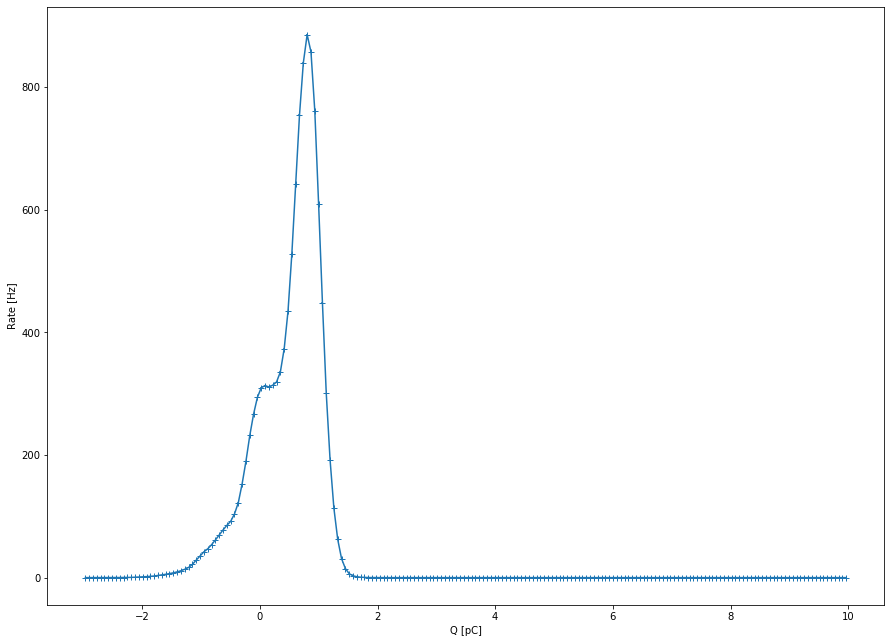

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200607_250_samples_100000_events', 1.9725000000000001, 0.06024381152297488, 0.008435851807812176]


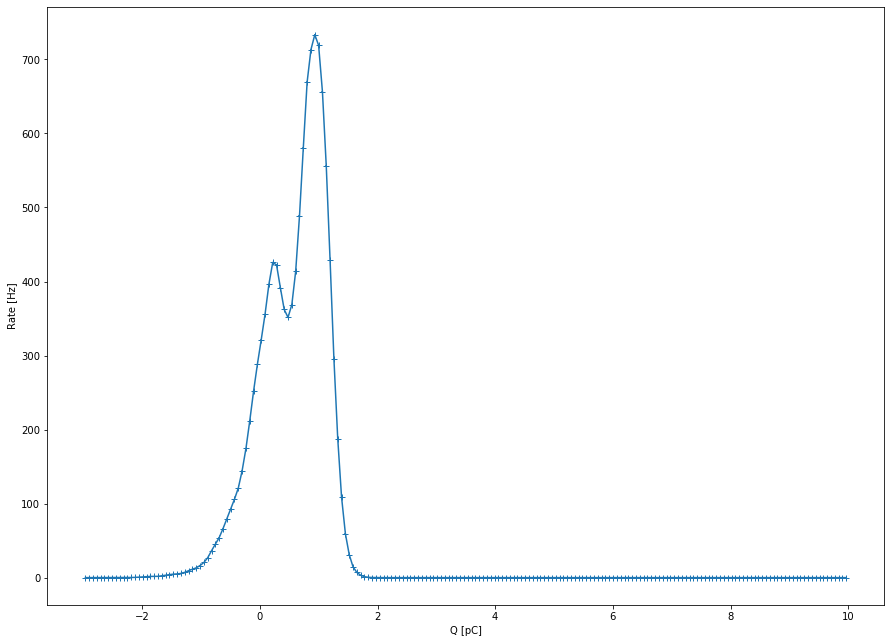

['/media/easystore/KA0206_LongDR_2020Q2/KA0206_BarrelFull_DR_200608_250_samples_100000_events', 1.9725000000000001, 0.07619659699828331, 0.009524594741537157]


In [5]:
allRuns = [fullAna(iF) for iF in fdirs]

In [6]:
allDR = np.array([iRun[0] for iRun in allRuns]).flatten()
allDRerr = np.array([iRun[1] for iRun in allRuns]).flatten()

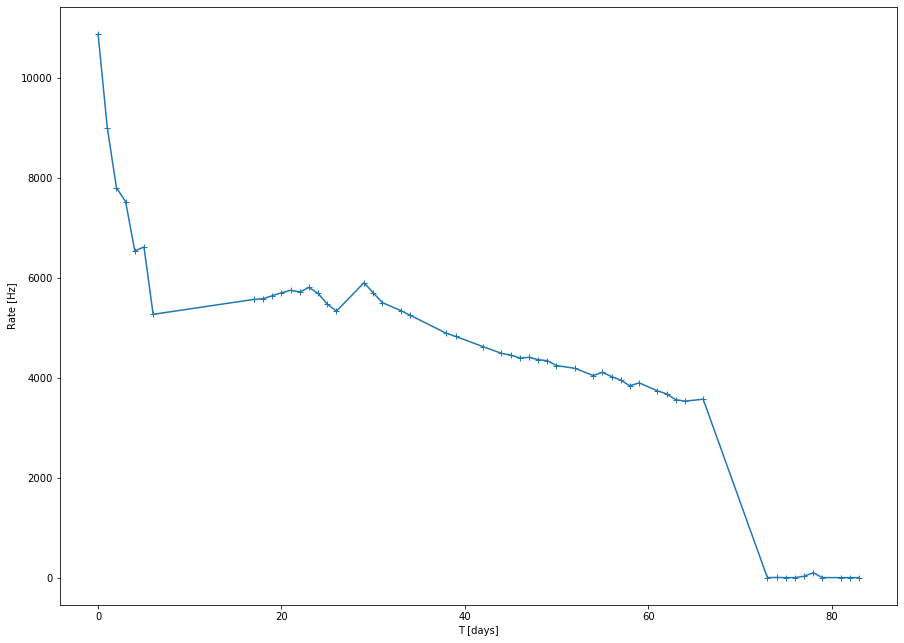

In [8]:
plt.errorbar(fdirT,allDR,marker='+',yerr=allDRerr)
plt.xlabel('T [days]')
plt.ylabel('Rate [Hz]')
plt.savefig("DarkRate.png")
plt.show()